# Decision Tree Regressor - Regresión
## Predicción de Tiempos de Entrega

### 1. ERROR A MEDIR
**RMSE (Root Mean Squared Error)**

Se ha escogido el RMSE como único evaluador para este modelo porque:
- Es interpretable en las mismas unidades que la variable objetivo (minutos)
- Penaliza más los errores grandes, lo cual es importante en predicción de tiempos de entrega
- Es ampliamente utilizado en problemas de regresión
- Permite comparar directamente con los otros modelos del experimento

### 2. VARIABLES DEL PROBLEMA

**Variable Dependiente (a predecir):**
- `Delivery_Time_min`: Tiempo de entrega en minutos

**Variables Independientes (features):**
- `Distance_km`: Distancia del pedido
- `Preparation_Time_min`: Tiempo de preparación
- `Courier_Experience_yrs`: Experiencia del courier
- `Weather`: Condiciones climáticas
- `Traffic_Level`: Nivel de tráfico

**Factores Controlables:**
- Tiempo de preparación (puede optimizarse en cocina)
- Selección del courier según experiencia
- Ruta de entrega

**Factores NO Controlables:**
- Distancia del cliente (ubicación geográfica)
- Clima (Weather)
- Nivel de tráfico (Traffic_Level)
- Día de la semana/hora del día

**Hiperparámetros seleccionados para el experimento:**
1. `max_depth`: Profundidad máxima del árbol
   - Controla la complejidad del modelo
   - Valores a probar: [5, 10, 15]
   
2. `min_samples_split`: Mínimo de muestras requeridas para dividir un nodo
   - Ayuda a controlar el sobreajuste
   - Valores a probar: [5, 10, 20]
   
3. `min_samples_leaf`: Mínimo de muestras requeridas en una hoja
   - Asegura que las predicciones se basen en suficientes datos
   - Valores a probar: [2, 4, 8]

In [8]:
# 1. Importaciones necesarias
import pandas as pd
import numpy as np
import time
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from itertools import product
import matplotlib.pyplot as plt

In [9]:
# 2. Cargar y preprocesar los datos
X_train = pd.read_csv("../Datos/Train_X.csv")
y_train = pd.read_csv("../Datos/Train_Y.csv").values.ravel()

X_val = pd.read_csv("../Datos/Validation_1.csv")
y_val = pd.read_csv("../Datos/Validation_2.csv").values.ravel()

X_test = pd.read_csv("../Datos/Test_1.csv")
y_test = pd.read_csv("../Datos/Test_2.csv").values.ravel()

# 1. Manejo de valores faltantes
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Para columnas numéricas, rellenar con la mediana
for col in numeric_cols:
    median_value = X_train[col].median()
    X_train[col] = X_train[col].fillna(median_value)
    X_val[col] = X_val[col].fillna(median_value)
    X_test[col] = X_test[col].fillna(median_value)

# Para columnas categóricas, rellenar con el modo
for col in categorical_cols:
    mode_value = X_train[col].mode()[0]
    X_train[col] = X_train[col].fillna(mode_value)
    X_val[col] = X_val[col].fillna(mode_value)
    X_test[col] = X_test[col].fillna(mode_value)

# 2. Preprocesamiento de variables categóricas
le = LabelEncoder()

for col in categorical_cols:
    if X_train[col].nunique() <= 5:  
        unique_vals = pd.concat([X_train[col], X_val[col], X_test[col]]).unique()
        le = LabelEncoder()
        le.fit(unique_vals)
        
        X_train[col] = le.transform(X_train[col])
        X_val[col] = le.transform(X_val[col])
        X_test[col] = le.transform(X_test[col])
    else: 
        train_dummies = pd.get_dummies(X_train[col], prefix=col)
        val_dummies = pd.get_dummies(X_val[col], prefix=col)
        test_dummies = pd.get_dummies(X_test[col], prefix=col)
        
        all_cols = train_dummies.columns.union(val_dummies.columns).union(test_dummies.columns)
        
        for dummy_col in all_cols:
            if dummy_col not in train_dummies.columns:
                train_dummies[dummy_col] = 0
            if dummy_col not in val_dummies.columns:
                val_dummies[dummy_col] = 0
            if dummy_col not in test_dummies.columns:
                test_dummies[dummy_col] = 0
        
        train_dummies = train_dummies.reindex(columns=all_cols)
        val_dummies = val_dummies.reindex(columns=all_cols)
        test_dummies = test_dummies.reindex(columns=all_cols)
        
        X_train = pd.concat([X_train.drop(col, axis=1), train_dummies], axis=1)
        X_val = pd.concat([X_val.drop(col, axis=1), val_dummies], axis=1)
        X_test = pd.concat([X_test.drop(col, axis=1), test_dummies], axis=1)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")

if X_train.isna().any().any() or X_val.isna().any().any() or X_test.isna().any().any():
    print("\nHay valores nulos en los datos!")

Train shape: (600, 8), Validation shape: (200, 8), Test shape: (200, 8)


In [ ]:
# 3. Definir combinaciones de hiperparámetros
params = {
    "max_depth": [5, 10, 15],
    "min_samples_split": [5, 10, 20],
    "min_samples_leaf": [2, 4, 8]
}

print("Hiperparámetros")
for k, v in params.items():
    print(f"  {k}: {v}")

🔧 Hiperparámetros a evaluar:
  max_depth: [5, 10, 15]
  min_samples_split: [5, 10, 20]
  min_samples_leaf: [2, 4, 8]


In [11]:
# 4. Entrenar y evaluar todas las combinaciones
resultados = []

for max_depth, min_samples_split, min_samples_leaf in product(
    params["max_depth"], params["min_samples_split"], params["min_samples_leaf"]
):
    start = time.time()
    
    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train, y_train)
    
    end = time.time()
    tiempo_total = end - start
    
    # Predicciones
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Métricas
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2_train = r2_score(y_train, y_train_pred)
    r2_val = r2_score(y_val, y_val_pred)
    
    resultados.append({
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
        "RMSE_Train": rmse_train,
        "RMSE_Val": rmse_val,
        "R2_Train": r2_train,
        "R2_Val": r2_val,
        "Tiempo (s)": round(tiempo_total, 3)
    })
    
    print(f"Modelo terminado: depth={max_depth}, split={min_samples_split}, leaf={min_samples_leaf}, tiempo={tiempo_total:.2f}s")

Modelo terminado: depth=5, split=5, leaf=2, tiempo=0.00s
Modelo terminado: depth=5, split=5, leaf=4, tiempo=0.00s
Modelo terminado: depth=5, split=5, leaf=8, tiempo=0.00s
Modelo terminado: depth=5, split=10, leaf=2, tiempo=0.00s
Modelo terminado: depth=5, split=10, leaf=4, tiempo=0.00s
Modelo terminado: depth=5, split=10, leaf=8, tiempo=0.00s
Modelo terminado: depth=5, split=20, leaf=2, tiempo=0.00s
Modelo terminado: depth=5, split=20, leaf=4, tiempo=0.00s
Modelo terminado: depth=5, split=20, leaf=8, tiempo=0.00s
Modelo terminado: depth=10, split=5, leaf=2, tiempo=0.00s
Modelo terminado: depth=10, split=5, leaf=4, tiempo=0.00s
Modelo terminado: depth=10, split=5, leaf=8, tiempo=0.00s
Modelo terminado: depth=10, split=10, leaf=2, tiempo=0.00s
Modelo terminado: depth=10, split=10, leaf=4, tiempo=0.00s
Modelo terminado: depth=10, split=10, leaf=8, tiempo=0.00s
Modelo terminado: depth=10, split=20, leaf=2, tiempo=0.00s
Modelo terminado: depth=10, split=20, leaf=4, tiempo=0.00s
Modelo termi

In [12]:
# 5. Crear tabla comparativa de resultados
df_resultados = pd.DataFrame(resultados)
df_resultados_sorted = df_resultados.sort_values(by="RMSE_Val")
print("Top 10 mejores modelos según RMSE:")
display(df_resultados_sorted.head(10))

print("\nMejor modelo:")
mejor = df_resultados_sorted.iloc[0]
print(mejor)

Top 10 mejores modelos según RMSE:


,max_depth,min_samples_split,min_samples_leaf,RMSE_Train,RMSE_Val,R2_Train,R2_Val,Tiempo (s)
2,5,5,8,10.761774,11.678582,0.768158,0.700169,0.003
5,5,10,8,10.761774,11.678582,0.768158,0.700169,0.004
7,5,20,4,10.840358,11.680355,0.764760,0.700078,0.003
8,5,20,8,10.840358,11.680355,0.764760,0.700078,0.004
11,10,5,8,9.756874,11.707738,0.809434,0.698670,0.003
14,10,10,8,9.756874,11.707738,0.809434,0.698670,0.003
20,15,5,8,9.756874,11.707738,0.809434,0.698670,0.004
23,15,10,8,9.756874,11.707738,0.809434,0.698670,0.004
1,5,5,4,10.626832,11.746210,0.773936,0.696687,0.004
4,5,10,4,10.666230,11.768599,0.772257,0.695529,0.003



Mejor modelo:
max_depth             5.000000
min_samples_split     5.000000
min_samples_leaf      8.000000
RMSE_Train           10.761774
RMSE_Val             11.678582
R2_Train              0.768158
R2_Val                0.700169
Tiempo (s)            0.003000
Name: 2, dtype: float64



--- Rendimiento final ---
RMSE (Test): 13.4464
R² (Test): 0.6163


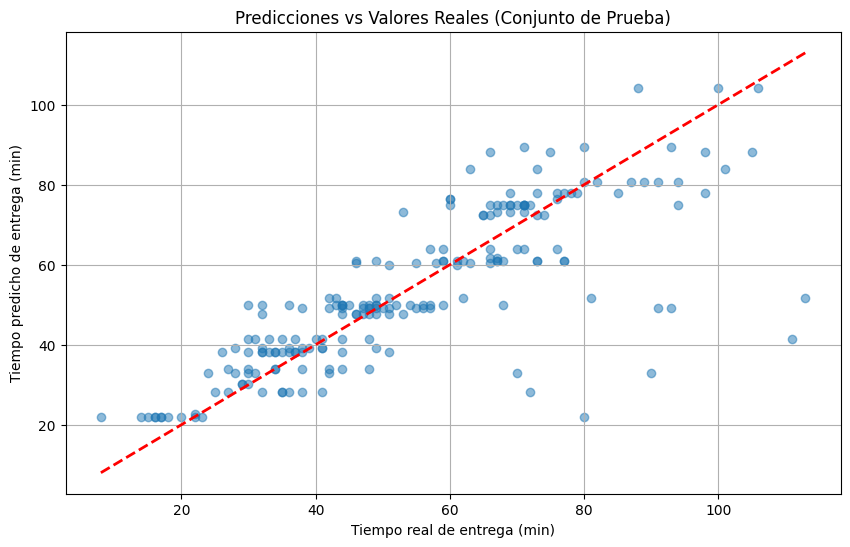

In [13]:
# 6. Evaluación final del mejor modelo
mejor_modelo = DecisionTreeRegressor(
    max_depth=int(mejor["max_depth"]),
    min_samples_split=int(mejor["min_samples_split"]),
    min_samples_leaf=int(mejor["min_samples_leaf"]),
    random_state=42
)
mejor_modelo.fit(X_train, y_train)

y_test_pred = mejor_modelo.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

print("\n--- Rendimiento final ---")
print(f"RMSE (Test): {rmse_test:.4f}")
print(f"R² (Test): {r2_test:.4f}")

# Visualización de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Tiempo real de entrega (min)')
plt.ylabel('Tiempo predicho de entrega (min)')
plt.title('Predicciones vs Valores Reales (Conjunto de Prueba)')
plt.grid(True)
plt.show()

In [14]:
# 7. Predicción con un dato inventado
columnas_modelo = X_train.columns
nuevo = pd.DataFrame(0, index=[0], columns=columnas_modelo)

# Establecer los valores básicos
nuevo['Distance_km'] = 5.0
nuevo['Preparation_Time_min'] = 20
nuevo['Courier_Experience_yrs'] = 2

# Las columnas dummy ya están en 0 por defecto
pred_nuevo = mejor_modelo.predict(nuevo)

print("\nPredicción para un nuevo pedido:")
print("Características del pedido:")
print(f"- Distancia: {nuevo['Distance_km'].iloc[0]:.1f} km")
print(f"- Tiempo de preparación: {nuevo['Preparation_Time_min'].iloc[0]} min")
print(f"- Experiencia del repartidor: {nuevo['Courier_Experience_yrs'].iloc[0]} años")
print(f"\nTiempo estimado de entrega: {pred_nuevo[0]:.2f} minutos")


Predicción para un nuevo pedido:
Características del pedido:
- Distancia: 5.0 km
- Tiempo de preparación: 20 min
- Experiencia del repartidor: 2 años

Tiempo estimado de entrega: 76.45 minutos
